In [1]:
%pip -q install soundfile scikit-learn torchvision matplotlib tqdm torchaudio

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os, json, math, random
from pathlib import Path

import numpy as np
import soundfile as sf
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt

import torchaudio


In [3]:
DATA_DIR = Path("./dataset")
OUT_DIR = Path("./artifacts_train")
OUT_DIR.mkdir(parents=True, exist_ok=True)

SEED = 42
TEST_SIZE = 0.1
VAL_SIZE = 0.1

TARGET_SR = 32000
CLIP_SECONDS = 5.0
TARGET_LEN = int(TARGET_SR * CLIP_SECONDS)

N_FFT = 1024
HOP = 320
N_MELS = 128
FMIN = 0.0
FMAX = TARGET_SR / 2

BATCH_SIZE = 32
NUM_WORKERS = 0
EPOCHS = 25
LR = 3e-4
WEIGHT_DECAY = 1e-4
LABEL_SMOOTHING = 0.0
USE_IMAGENET_WEIGHTS = True

TIME_MASK_PCT = 0.15   # до 15% по времени
FREQ_MASK_PCT = 0.15   # до 15% по мел-частотам
N_TIME_MASKS = 2
N_FREQ_MASKS = 2


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE: ", DEVICE)

DEVICE:  cuda


In [4]:
assert DATA_DIR.exists(), f"Нет папки: {DATA_DIR}"

CLASSES = sorted([p.name for p in DATA_DIR.iterdir() if p.is_dir()])
label2idx = {c:i for i,c in enumerate(CLASSES)}
idx2label = {i:c for c,i in label2idx.items()}
NUM_CLASSES = len(CLASSES)

all_paths = sorted([p for p in DATA_DIR.rglob("*.wav") if p.parent.name in label2idx])
all_labels = np.array([label2idx[p.parent.name] for p in all_paths], dtype=np.int64)

counts = np.bincount(all_labels, minlength=NUM_CLASSES)
print("Classes:", NUM_CLASSES, "Total wav:", len(all_paths))
for c, n in sorted(zip(CLASSES, counts), key=lambda x: x[1], reverse=True):
    print(f"{c:25s} {n}")
print("min:", counts.min(), "max:", counts.max(), "avg:", round(counts.mean(), 2))

# сохраняем классы (важно для инференса)
json.dump(CLASSES, open(OUT_DIR/"classes.json", "w", encoding="utf-8"), ensure_ascii=False, indent=2)
json.dump(label2idx, open(OUT_DIR/"label2idx.json", "w", encoding="utf-8"), ensure_ascii=False, indent=2)
print("Saved:", OUT_DIR/"classes.json")


Classes: 16 Total wav: 2995
anas_platyrhynchos        200
ardea_cinerea             200
carduelis_carduelis       200
coloeus_monedula          200
columba_palumbus          200
corvus_frugilegus         200
fringilla_coelebs         200
hirundo_rustica           200
motacilla_alba            200
parus_major               200
pica_pica                 200
strix_aluco               200
turdus_merula             200
luscinia_svecica          188
luscinia_luscinia         173
turdus_ruficollis         34
min: 34 max: 200 avg: 187.19
Saved: artifacts_train/classes.json


In [5]:
trainval_paths, test_paths, trainval_y, test_y = train_test_split(
    all_paths, all_labels, test_size=TEST_SIZE, random_state=SEED, stratify=all_labels
)
val_size_rel = VAL_SIZE / (1.0 - TEST_SIZE)
train_paths, val_paths, train_y, val_y = train_test_split(
    trainval_paths, trainval_y, test_size=val_size_rel, random_state=SEED, stratify=trainval_y
)

print("Total:", len(all_paths))
print("Train:", len(train_paths), "Val:", len(val_paths), "Test:", len(test_paths))

def split_stats(name, y):
    c = np.bincount(y, minlength=NUM_CLASSES)
    print(f"{name:5s} min={c.min()} max={c.max()} (sum={c.sum()})")

split_stats("Train", train_y)
split_stats("Val", val_y)
split_stats("Test", test_y)


Total: 2995
Train: 2395 Val: 300 Test: 300
Train min=27 max=160 (sum=2395)
Val   min=3 max=20 (sum=300)
Test  min=4 max=20 (sum=300)


In [6]:
def resample_if_needed(x: np.ndarray, sr: int, target_sr: int) -> np.ndarray:
    if sr == target_sr:
        return x
    xt = torch.from_numpy(x).float().unsqueeze(0)  # [1, T]
    xt = torchaudio.functional.resample(xt, sr, target_sr)
    return xt.squeeze(0).cpu().numpy()


def crop_or_pad(x: np.ndarray, target_len: int, train: bool) -> np.ndarray:
    T = x.shape[0]
    if T > target_len:
        if train:
            start = np.random.randint(0, T - target_len + 1)
        else:
            start = (T - target_len) // 2
        return x[start:start+target_len]
    if T < target_len:
        pad = target_len - T
        return np.pad(x, (0, pad), mode="constant")
    return x

def mel_fbanks(n_freqs: int, sr: int) -> torch.Tensor:
    fb = torchaudio.functional.melscale_fbanks(
        n_freqs=n_freqs,
        f_min=FMIN,
        f_max=FMAX,
        n_mels=N_MELS,
        sample_rate=sr,
        norm=None,
        mel_scale="htk",
    )
    # fb shape: [n_freqs, n_mels]
    return fb

_FBANKS = None
_WINDOW = None

def audio_to_logmel(x: np.ndarray, sr: int) -> torch.Tensor:
    global _FBANKS, _WINDOW
    if _WINDOW is None:
        _WINDOW = torch.hann_window(N_FFT)

    xt = torch.from_numpy(x).float()  # [T]
    stft = torch.stft(
        xt, n_fft=N_FFT, hop_length=HOP, win_length=N_FFT,
        window=_WINDOW, center=True, return_complex=True
    )  # [freq, frames]
    spec = (stft.abs() ** 2)  # power

    n_freqs = spec.shape[0]
    if _FBANKS is None or _FBANKS.shape[0] != n_freqs:
        _FBANKS = mel_fbanks(n_freqs=n_freqs, sr=sr)  # [n_freqs, n_mels]

    mel = spec.transpose(0, 1) @ _FBANKS  # [frames, n_mels]
    mel = mel.transpose(0, 1)            # [n_mels, frames]

    logmel = torch.log(mel + 1e-10)      # log
    # нормализация по примеру
    logmel = (logmel - logmel.mean()) / (logmel.std() + 1e-6)

    # [3, n_mels, frames]
    return logmel.unsqueeze(0).repeat(3, 1, 1)

def spec_augment(x: torch.Tensor) -> torch.Tensor:
    """
    x: [C, n_mels, frames]
    """
    C, F, T = x.shape

    # time masks
    max_tw = max(1, int(T * TIME_MASK_PCT))
    for _ in range(N_TIME_MASKS):
        tw = random.randint(1, max_tw)
        t0 = random.randint(0, max(0, T - tw))
        x[:, :, t0:t0+tw] = 0.0

    # freq masks
    max_fw = max(1, int(F * FREQ_MASK_PCT))
    for _ in range(N_FREQ_MASKS):
        fw = random.randint(1, max_fw)
        f0 = random.randint(0, max(0, F - fw))
        x[:, f0:f0+fw, :] = 0.0

    return x


class BirdLogMelDataset(Dataset):
    def __init__(self, paths, labels, train: bool):
        self.paths = list(paths)
        self.labels = np.array(labels, dtype=np.int64)
        self.train = train

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, i):
        p = self.paths[i]
        y = int(self.labels[i])

        wav, sr = sf.read(str(p), always_2d=True)
        wav = wav.mean(axis=1).astype(np.float32)  # mono
        wav = resample_if_needed(wav, sr, TARGET_SR)
        wav = crop_or_pad(wav, TARGET_LEN, train=self.train)

        X = audio_to_logmel(wav, TARGET_SR)  # [3, n_mels, frames]

        if self.train:
            X = spec_augment(X)

        return X, y



In [7]:
train_counts = np.bincount(train_y, minlength=NUM_CLASSES)
class_w = 1.0 / np.maximum(train_counts, 1)
sample_w = class_w[train_y]

sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_w, dtype=torch.double),
    num_samples=len(sample_w),
    replacement=True
)

train_ds = BirdLogMelDataset(train_paths, train_y, train=True)
val_ds   = BirdLogMelDataset(val_paths,   val_y,   train=False)
test_ds  = BirdLogMelDataset(test_paths,  test_y,  train=False)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                      num_workers=NUM_WORKERS, pin_memory=(DEVICE=="cuda"))
val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=(DEVICE=="cuda"))
test_dl  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=(DEVICE=="cuda"))

print("OK loaders. Train batches:", len(train_dl), "Val:", len(val_dl), "Test:", len(test_dl))
print("Train raw class min/max:", train_counts.min(), train_counts.max())


OK loaders. Train batches: 75 Val: 10 Test: 10
Train raw class min/max: 27 160


In [8]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

def make_model(num_classes: int):
    if USE_IMAGENET_WEIGHTS:
        model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
    else:
        model = efficientnet_b0(weights=None)
    in_f = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_f, num_classes)
    return model

model = make_model(NUM_CLASSES).to(DEVICE)

criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scaler = torch.amp.GradScaler(enabled=(DEVICE=="cuda"))

In [9]:
@torch.no_grad()
def evalute(model, dl):
    model.eval()
    all_pred, all_true = [], []
    total_loss = 0.0
    n = 0
    for x, y in dl:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        logits = model(x)
        loss = criterion(logits, y)

        total_loss += loss.item() * y.size(0)
        n += y.size(0)

        pred = logits.argmax(1).detach().cpu().numpy()
        true = y.detach().cpu().numpy()
        all_pred.append(pred)
        all_true.append(true)

    all_pred = np.concatenate(all_pred)
    all_true = np.concatenate(all_true)
    
    acc = (all_pred == all_true).mean()
    fim = f1_score(all_true, all_pred, average="macro")
    return total_loss / max(n, 1), acc, fim

def train_one_epoch(model, dl):
    model.train()
    total_loss = 0.0
    n = 0
    pbar = tqdm(dl, desc="train", leave=False)
    for x, y in pbar:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(device_type="cuda", enabled=(DEVICE=="cuda")):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * y.size(0)
        n += y.size(0)
        pbar.set_postfix(loss=total_loss/max(n,1))

    return total_loss / max(n, 1)

In [10]:
best_f1 = -1.0
best_path = OUT_DIR/"best.pth"

for epoch in range(1, EPOCHS + 1):
    tr_loss = train_one_epoch(model, train_dl)
    val_loss, val_acc, val_f1 = evalute(model, val_dl)

    print(
        f"Epoch {epoch:02d}/{EPOCHS} |"
        f"train_loss={tr_loss:.4f} | val_loss={val_loss:.4f} | " 
        f"val_acc={val_acc:.4f} val_f1={val_f1:.4f}"
    )

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save({
            "model": model.state_dict(),
            "classes": CLASSES,
            "label2idx": label2idx,
            "config": {
                "TARGET_SR": TARGET_SR,
                "CLIP_SECONDS": CLIP_SECONDS,
                "N_FFT": N_FFT,
                "HOP": HOP,
                "N_MELS": N_MELS
            }
        }, best_path)
        print("Saved best model:", best_path)

print("Best val macro-F1: ", best_f1)

Epoch 01/25 |train_loss=2.4537 | val_loss=1.8096 | val_acc=0.4100 val_f1=0.3867
Saved best model: artifacts_train/best.pth


Epoch 02/25 |train_loss=1.6163 | val_loss=1.0940 | val_acc=0.6500 val_f1=0.6238
Saved best model: artifacts_train/best.pth


Epoch 03/25 |train_loss=1.2043 | val_loss=0.9344 | val_acc=0.7433 val_f1=0.7231
Saved best model: artifacts_train/best.pth


Epoch 04/25 |train_loss=1.0174 | val_loss=0.8681 | val_acc=0.7267 val_f1=0.7050


Epoch 05/25 |train_loss=0.9140 | val_loss=0.8161 | val_acc=0.7633 val_f1=0.7509
Saved best model: artifacts_train/best.pth


Epoch 06/25 |train_loss=0.7960 | val_loss=0.8002 | val_acc=0.7400 val_f1=0.7194


Epoch 07/25 |train_loss=0.6296 | val_loss=0.8096 | val_acc=0.7533 val_f1=0.7340


Epoch 08/25 |train_loss=0.6770 | val_loss=0.7924 | val_acc=0.7833 val_f1=0.7681
Saved best model: artifacts_train/best.pth


Epoch 09/25 |train_loss=0.5928 | val_loss=0.7476 | val_acc=0.7833 val_f1=0.7598


Epoch 10/25 |train_loss=0.5843 | val_loss=0.8011 | val_acc=0.7767 val_f1=0.7618


Epoch 11/25 |train_loss=0.5664 | val_loss=0.6869 | val_acc=0.7900 val_f1=0.7880
Saved best model: artifacts_train/best.pth


Epoch 12/25 |train_loss=0.5348 | val_loss=0.7297 | val_acc=0.7967 val_f1=0.7921
Saved best model: artifacts_train/best.pth


Epoch 13/25 |train_loss=0.5072 | val_loss=0.7745 | val_acc=0.7733 val_f1=0.7519


Epoch 14/25 |train_loss=0.4679 | val_loss=0.8085 | val_acc=0.7800 val_f1=0.7597


Epoch 15/25 |train_loss=0.4341 | val_loss=0.7203 | val_acc=0.8067 val_f1=0.8072
Saved best model: artifacts_train/best.pth


Epoch 16/25 |train_loss=0.4009 | val_loss=0.7711 | val_acc=0.8167 val_f1=0.8064


Epoch 17/25 |train_loss=0.4365 | val_loss=0.7469 | val_acc=0.8100 val_f1=0.7935


Epoch 18/25 |train_loss=0.4388 | val_loss=0.7039 | val_acc=0.8167 val_f1=0.7987


Epoch 19/25 |train_loss=0.3828 | val_loss=0.7830 | val_acc=0.7833 val_f1=0.7674


Epoch 20/25 |train_loss=0.3957 | val_loss=0.7190 | val_acc=0.8100 val_f1=0.7883


Epoch 21/25 |train_loss=0.3504 | val_loss=0.7376 | val_acc=0.8067 val_f1=0.7879


Epoch 22/25 |train_loss=0.3550 | val_loss=0.8046 | val_acc=0.8033 val_f1=0.7863


Epoch 23/25 |train_loss=0.3036 | val_loss=0.7514 | val_acc=0.8200 val_f1=0.7959


Epoch 24/25 |train_loss=0.3223 | val_loss=0.7478 | val_acc=0.8033 val_f1=0.7912


Epoch 25/25 |train_loss=0.3160 | val_loss=0.7211 | val_acc=0.8133 val_f1=0.7966
Best val macro-F1:  0.8071687867580037


test: 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


Test accuracy:  0.81
Test macro-F1:  0.8027630424816898

 Classification report:
                      precision    recall  f1-score   support

 anas_platyrhynchos      0.900     0.900     0.900        20
      ardea_cinerea      0.933     0.700     0.800        20
carduelis_carduelis      1.000     0.900     0.947        20
   coloeus_monedula      0.810     0.850     0.829        20
   columba_palumbus      0.857     0.900     0.878        20
  corvus_frugilegus      0.783     0.900     0.837        20
  fringilla_coelebs      0.632     0.600     0.615        20
    hirundo_rustica      0.895     0.850     0.872        20
  luscinia_luscinia      0.929     0.765     0.839        17
   luscinia_svecica      0.625     0.789     0.698        19
     motacilla_alba      0.842     0.800     0.821        20
        parus_major      0.696     0.800     0.744        20
          pica_pica      0.889     0.800     0.842        20
        strix_aluco      0.769     1.000     0.870        20
  

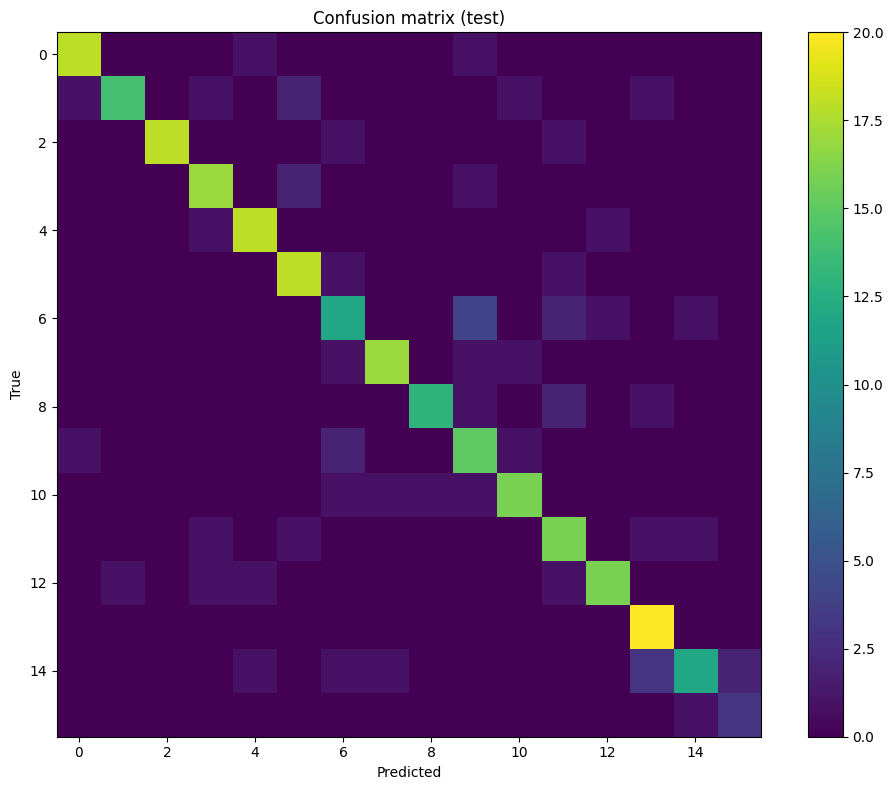

In [12]:
ckpt = torch.load(best_path, map_location=DEVICE)
model.load_state_dict(ckpt["model"])
model.eval()

@torch.no_grad()
def predict_all(dl):
    preds, trues = [], []
    for x, y in tqdm(dl, desc="test"):
        x = x.to(DEVICE, non_blocking=True)
        logits = model(x)
        pred = logits.argmax(1).cpu().numpy()
        true = y.numpy()
        preds.append(pred)
        trues.append(true)
    return np.concatenate(preds), np.concatenate(trues)

pred, true = predict_all(test_dl)

print("Test accuracy: ", (pred == true).mean())
print("Test macro-F1: ", f1_score(true, pred, average="macro"))
print("\n Classification report:\n", classification_report(true, pred, target_names=CLASSES, digits=3))

cm = confusion_matrix(true, pred)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion matrix (test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.show()


In [13]:
# %% TTA multi-crop evaluation on TEST

ckpt = torch.load(best_path, map_location=DEVICE)
model.load_state_dict(ckpt["model"])
model.eval()

def make_crops(wav: np.ndarray, target_len: int, n_crops: int, train: bool=False):
    T = wav.shape[0]
    if T <= target_len:
        return [crop_or_pad(wav, target_len, train=False)]

    if n_crops <= 1:
        # центр
        start = (T - target_len) // 2
        return [wav[start:start+target_len]]

    # равномерно по длине
    starts = np.linspace(0, T - target_len, n_crops).astype(int)
    return [wav[s:s+target_len] for s in starts]

@torch.no_grad()
def predict_file_logits_tta(path: Path, n_crops: int = 5):
    wav, sr = sf.read(str(path), always_2d=True)
    wav = wav.mean(axis=1).astype(np.float32)
    wav = resample_if_needed(wav, sr, TARGET_SR)

    crops = make_crops(wav, TARGET_LEN, n_crops=n_crops)
    logits_sum = None

    for c in crops:
        X = audio_to_logmel(c, TARGET_SR).unsqueeze(0).to(DEVICE)  # [1,3,M,T]
        logits = model(X)  # [1, num_classes]
        logits_sum = logits if logits_sum is None else (logits_sum + logits)

    logits_avg = logits_sum / len(crops)
    return logits_avg.squeeze(0)  # [num_classes]

@torch.no_grad()
def test_with_tta(paths, labels, n_crops=5):
    preds = []
    trues = np.array(labels, dtype=np.int64)

    for p in tqdm(paths, desc=f"test TTA x{n_crops}"):
        logits = predict_file_logits_tta(p, n_crops=n_crops)
        pred = int(torch.argmax(logits).item())
        preds.append(pred)

    preds = np.array(preds, dtype=np.int64)
    acc = (preds == trues).mean()
    f1m = f1_score(trues, preds, average="macro")
    return preds, trues, acc, f1m

pred, true, acc, f1m = test_with_tta(test_paths, test_y, n_crops=5)

print("Test accuracy (TTA):", acc)
print("Test macro-F1 (TTA):", f1m)
print("\nClassification report (TTA):")
print(classification_report(true, pred, target_names=CLASSES, digits=3))


test TTA x5: 100%|██████████| 300/300 [00:31<00:00,  9.63it/s]

Test accuracy (TTA): 0.8766666666666667
Test macro-F1 (TTA): 0.8700732355217738

Classification report (TTA):
                     precision    recall  f1-score   support

 anas_platyrhynchos      1.000     0.900     0.947        20
      ardea_cinerea      0.944     0.850     0.895        20
carduelis_carduelis      0.952     1.000     0.976        20
   coloeus_monedula      0.905     0.950     0.927        20
   columba_palumbus      0.905     0.950     0.927        20
  corvus_frugilegus      0.792     0.950     0.864        20
  fringilla_coelebs      0.737     0.700     0.718        20
    hirundo_rustica      0.941     0.800     0.865        20
  luscinia_luscinia      0.933     0.824     0.875        17
   luscinia_svecica      0.739     0.895     0.810        19
     motacilla_alba      0.895     0.850     0.872        20
        parus_major      0.783     0.900     0.837        20
          pica_pica      0.889     0.800     0.842        20
        strix_aluco      0.952     